In [31]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import re
import math
import os
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

In [23]:
# Procedure to find keyword matches in text
def get_matches(text, keywords):
    pattern = f'|'.join([keyword.lower() for keyword in keywords])
    return re.findall(pattern, text.lower())
#end

In [24]:
# Get DBLP data for conferences
conf = pd.read_csv('../DBLP/cdblp.csv', sep='\t', index_col=False)
conf = conf.rename(index=str, columns={'booktitle': 'venue'})
conf['venue_type'] = conf['key'].map(lambda x: 'conf')
# Get DBLP data for journals
journal = pd.read_csv('../DBLP/jdblp.csv', sep='\t', index_col=False)
journal = journal.rename(index=str, columns={'journal': 'venue'})
journal['venue_type'] = journal['key'].map(lambda x: 'journal')
# Merge conf and journal data into a single DataFrame
titles = pd.DataFrame(columns=['year','venue_type','venue','title','classical','trending','ethics'])
titles = titles.append(conf)
titles = titles.append(journal)

In [25]:
# Get classical, trending, ethics keywords
keywords = {
    'classical': [ line.strip() for line in open('../DBLP/classical_keywords.txt').readlines() ],
    'trending': [ line.strip() for line in open('../DBLP/trending_keywords.txt').readlines() ],
    'ethics': [ line.strip() for line in open('../DBLP/ethics_keywords.txt').readlines() ]
}

In [26]:
# For each publication, compute whether its title matches with classical, ethics or trending keywords
for keyword_type in ['classical','trending','ethics']:
    titles[keyword_type] = titles['title'].map(lambda x: len(get_matches(str(x),keywords[keyword_type])) )
    titles[f'{keyword_type}_binary'] = titles[keyword_type].map(lambda x: 1 if x > 0 else 0)
#end

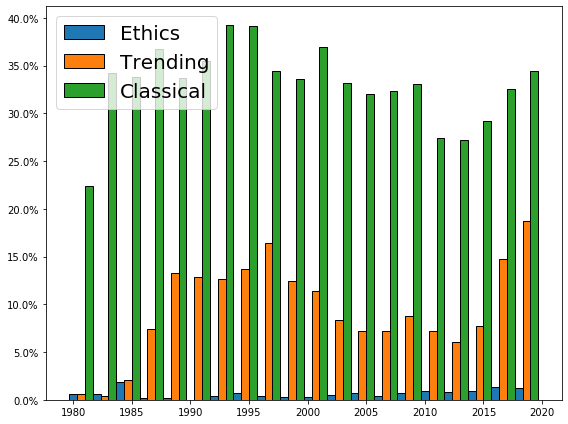

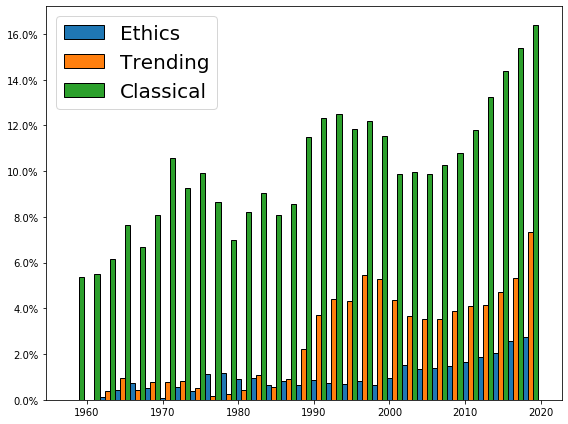

In [32]:
# Filter selected conferences (leading AI confs)
selected_confs = ['AAAI','ICMLA','NIPS','ICML','IJCAI','ICMLC']
titles = titles[(titles['venue_type']=='journal') | (titles['venue'].isin(selected_confs))]

# Quantize publication dates into 2 year buckets, to limit the number of bars and simplify the barplot
titles_2year = titles.copy()
titles_2year['year'] = titles_2year['year'].map(lambda x: 2*(x//2))
# Group by year
matches_by_year = titles_2year.groupby([titles_2year['venue_type'],titles_2year['year']]).sum().reset_index()
matches_by_year['total'] = list(titles_2year.groupby([titles_2year['venue_type'],titles_2year['year']]).size())
# Remove current year
matches_by_year = matches_by_year[matches_by_year['year'] <= 2018]

# Draw barplots for confs and journals titles
for venue_type in ['conf','journal']:
    
    df = matches_by_year[matches_by_year['venue_type']==venue_type]
    df['classical_binary'] = 100 * df['classical_binary'] / df['total']
    df['trending_binary'] = 100 * df['trending_binary'] / df['total']
    df['ethics_binary'] = 100 * df['ethics_binary'] / df['total']
    
    if venue_type == 'conf': df = df[df['year'] >= 1980];

    fig,ax = plt.subplots(figsize=(8,6))
    ax.bar(np.array(df['year']), np.array(df['ethics_binary']), width=2./3, edgecolor='black', label='Ethics')
    ax.bar(np.array(df['year'])+2./3, np.array(df['trending_binary']), width=2./3, edgecolor='black', label='Trending')
    ax.bar(np.array(df['year'])+4./3, np.array(df['classical_binary']), width=2./3, edgecolor='black', label='Classical')

    ax.legend(loc='upper left', fontsize=20)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.tight_layout()
    plt.savefig(f'../Figures/{venue_type}-per-year-side-by-side.png',format='png')
#end

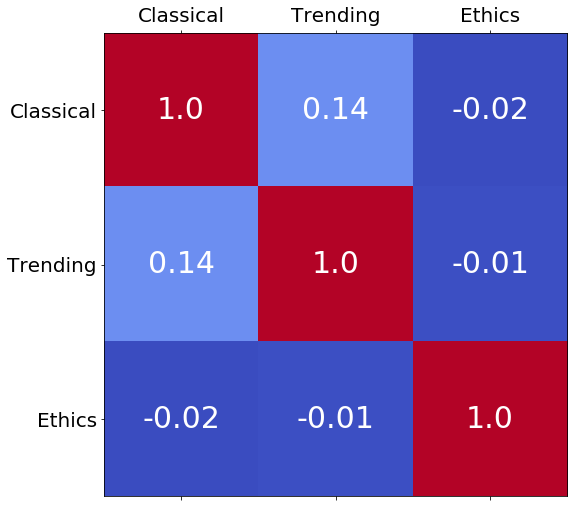

In [33]:
# Draw correlation matrix
corr = titles[['classical','trending','ethics']].corr()
fig, ax = plt.subplots(figsize=(8,8))
ax.matshow(corr, cmap=plt.cm.coolwarm)
plt.xticks(range(len(corr.columns)),[x.title() for x in corr.columns], fontsize=20);
plt.yticks(range(len(corr.columns)),[x.title() for x in corr.columns], fontsize=20);
for i,k1 in enumerate(['classical','trending','ethics']):
    for j,k2 in enumerate(['classical','trending','ethics']):
        text = ax.text(j, i, corr[k1][k2].round(2), fontsize=30, ha="center", va="center", color="white")
    #end
#end
plt.tight_layout()
plt.savefig('../Figures/correlation-matrix.png',format='png')

In [34]:
abstracts_aaai = pd.read_csv('../Abstracts/aaai.txt', sep=';', index_col=False)
abstracts_nips = pd.read_csv('../Abstracts/nips.txt', sep=';', index_col=False)
abstracts_aaai['venue'] = abstracts_aaai['key'].map(lambda x: 'AAAI')
abstracts_nips['venue'] = abstracts_aaai['key'].map(lambda x: 'NIPS')
abstracts = abstracts_aaai.append(abstracts_nips)
abstracts['abstract'] = abstracts['abstract'].map(lambda x: str(x))

In [35]:
# For each publication, compute whether its abstract matches with classical, ethics or trending keywords
for keyword_type in ['classical','trending','ethics']:
    abstracts[keyword_type] = abstracts['abstract'].map(lambda x: len(get_matches(str(x[1:-1]),keywords[keyword_type])) )
    abstracts[f'{keyword_type}_binary'] = abstracts[keyword_type].map(lambda x: 1 if x > 0 else 0)
#end

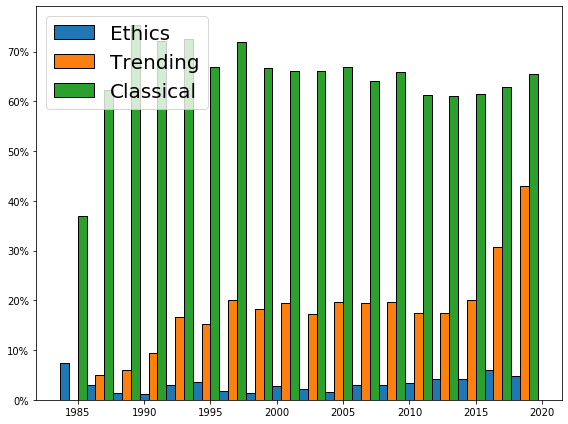

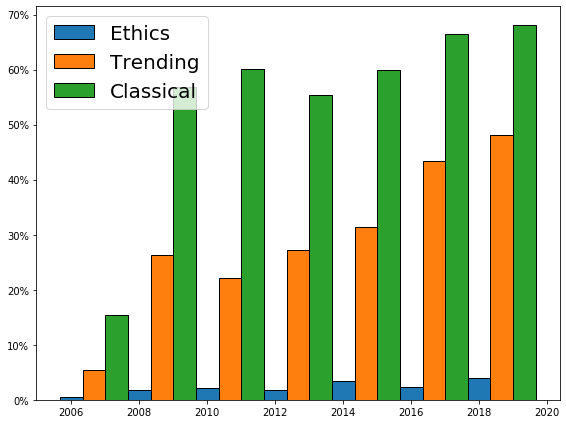

In [36]:
# Quantize publication dates into 2 year buckets, to limit the number of bars and simplify the barplot
abstracts_2year = abstracts.copy()
abstracts_2year = abstracts[abstracts['year'] != ''] # Filter out blank dates
abstracts_2year['year'] = abstracts_2year['year'].map(lambda x: 2*(int(x)//2))
# Group by year
matches_by_year = abstracts_2year.groupby([abstracts_2year['venue'],abstracts_2year['year']]).sum().reset_index()
matches_by_year['total'] = list(abstracts_2year.groupby([abstracts_2year['venue'],abstracts_2year['year']]).size())
# Remove current year
matches_by_year = matches_by_year[matches_by_year['year'] <= 2018]

# Draw barplots for AAAI and NIPS abstracts
for venue in ['AAAI','NIPS']:
    
    df = matches_by_year[matches_by_year['venue']==venue]    
    df['classical_binary'] = 100 * df['classical_binary'] / df['total']
    df['trending_binary'] = 100 * df['trending_binary'] / df['total']
    df['ethics_binary'] = 100 * df['ethics_binary'] / df['total']
    
    if venue == 'NIPS':
        df = df[df['year'] >= 2005 ]

    fig,ax = plt.subplots(figsize=(8,6))
    ax.bar(np.array(df['year']), np.array(df['ethics_binary']), width=2./3, edgecolor='black', label='Ethics')
    ax.bar(np.array(df['year'])+2./3, np.array(df['trending_binary']), width=2./3, edgecolor='black', label='Trending')
    ax.bar(np.array(df['year'])+4./3, np.array(df['classical_binary']), width=2./3, edgecolor='black', label='Classical')

    ax.legend(loc='upper left', fontsize=20)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.tight_layout()
    plt.savefig(f'../Figures/{venue}-per-year.png',format='png')
#end